In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.display import SVG, display
from graphviz import Source
from mlxtend.plotting import plot_decision_regions
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df = pd.read_csv("default of credit card clients.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# Null value composition
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [ ]:
# deal with outliers in a specified column
def rmvOutlier(df,colName):
    q1 = df[colName].quantile(0.25)
    q3 = df[colName].quantile(0.75)
    interq = q3-q1
    fenceLow = q1-1.5*interq
    fenceHigh = q3+1.5*interq
    df_out =  df.loc[(df[colName] > fenceLow) & (df[colName] < fenceHigh)]
    return df_out

In [ ]:
df['Amount'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6'] - df['PAY_AMT1'] - df['PAY_AMT2']
- df['PAY_AMT3'] - df['PAY_AMT4'] - df['PAY_AMT5'] - df['PAY_AMT6']

0              0
1          -4000
2          -8000
3          -4369
4         -20368
5          -3457
6         -85759
7          -3810
8          -3432
9         -14129
10         -4154
11        -34524
12        -15870
13         -7500
14        -12000
15         -4700
16         -3150
17       -341539
18             0
19             0
20        -37694
21          -948
22         -5421
23         -1688
24        -10643
25         -4492
26         -1500
27         -4512
28        -32731
29         -3600
30        -66938
31         -3716
32        -12210
33       -131523
34         -9241
35         -1753
36        -25837
37        -50331
38             0
39        -28282
40       -226840
41        -11842
42         -2800
43        -14000
44         -5000
45             0
46        -17075
47             0
48        -56654
49         -3613
50         -5000
51         -6000
52        -15193
53         -6936
54         -9549
55         -2681
56        -19179
57        -18683
58         -19

In [ ]:
df = rmvOutlier(df, 'Amount')
df.shape

(27427, 26)

In [ ]:
columns_to_drop = ['SEX', 'MARRIAGE', 'AGE']
df = df.drop(columns=columns_to_drop)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# Data type display
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27427 entries, 0 to 27426
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          27427 non-null  int64
 1   LIMIT_BAL                   27427 non-null  int64
 2   EDUCATION                   27427 non-null  int64
 3   PAY_0                       27427 non-null  int64
 4   PAY_2                       27427 non-null  int64
 5   PAY_3                       27427 non-null  int64
 6   PAY_4                       27427 non-null  int64
 7   PAY_5                       27427 non-null  int64
 8   PAY_6                       27427 non-null  int64
 9   BILL_AMT1                   27427 non-null  int64
 10  BILL_AMT2                   27427 non-null  int64
 11  BILL_AMT3                   27427 non-null  int64
 12  BILL_AMT4                   27427 non-null  int64
 13  BILL_AMT5                   27427 non-null  int64
 14  BILL_A

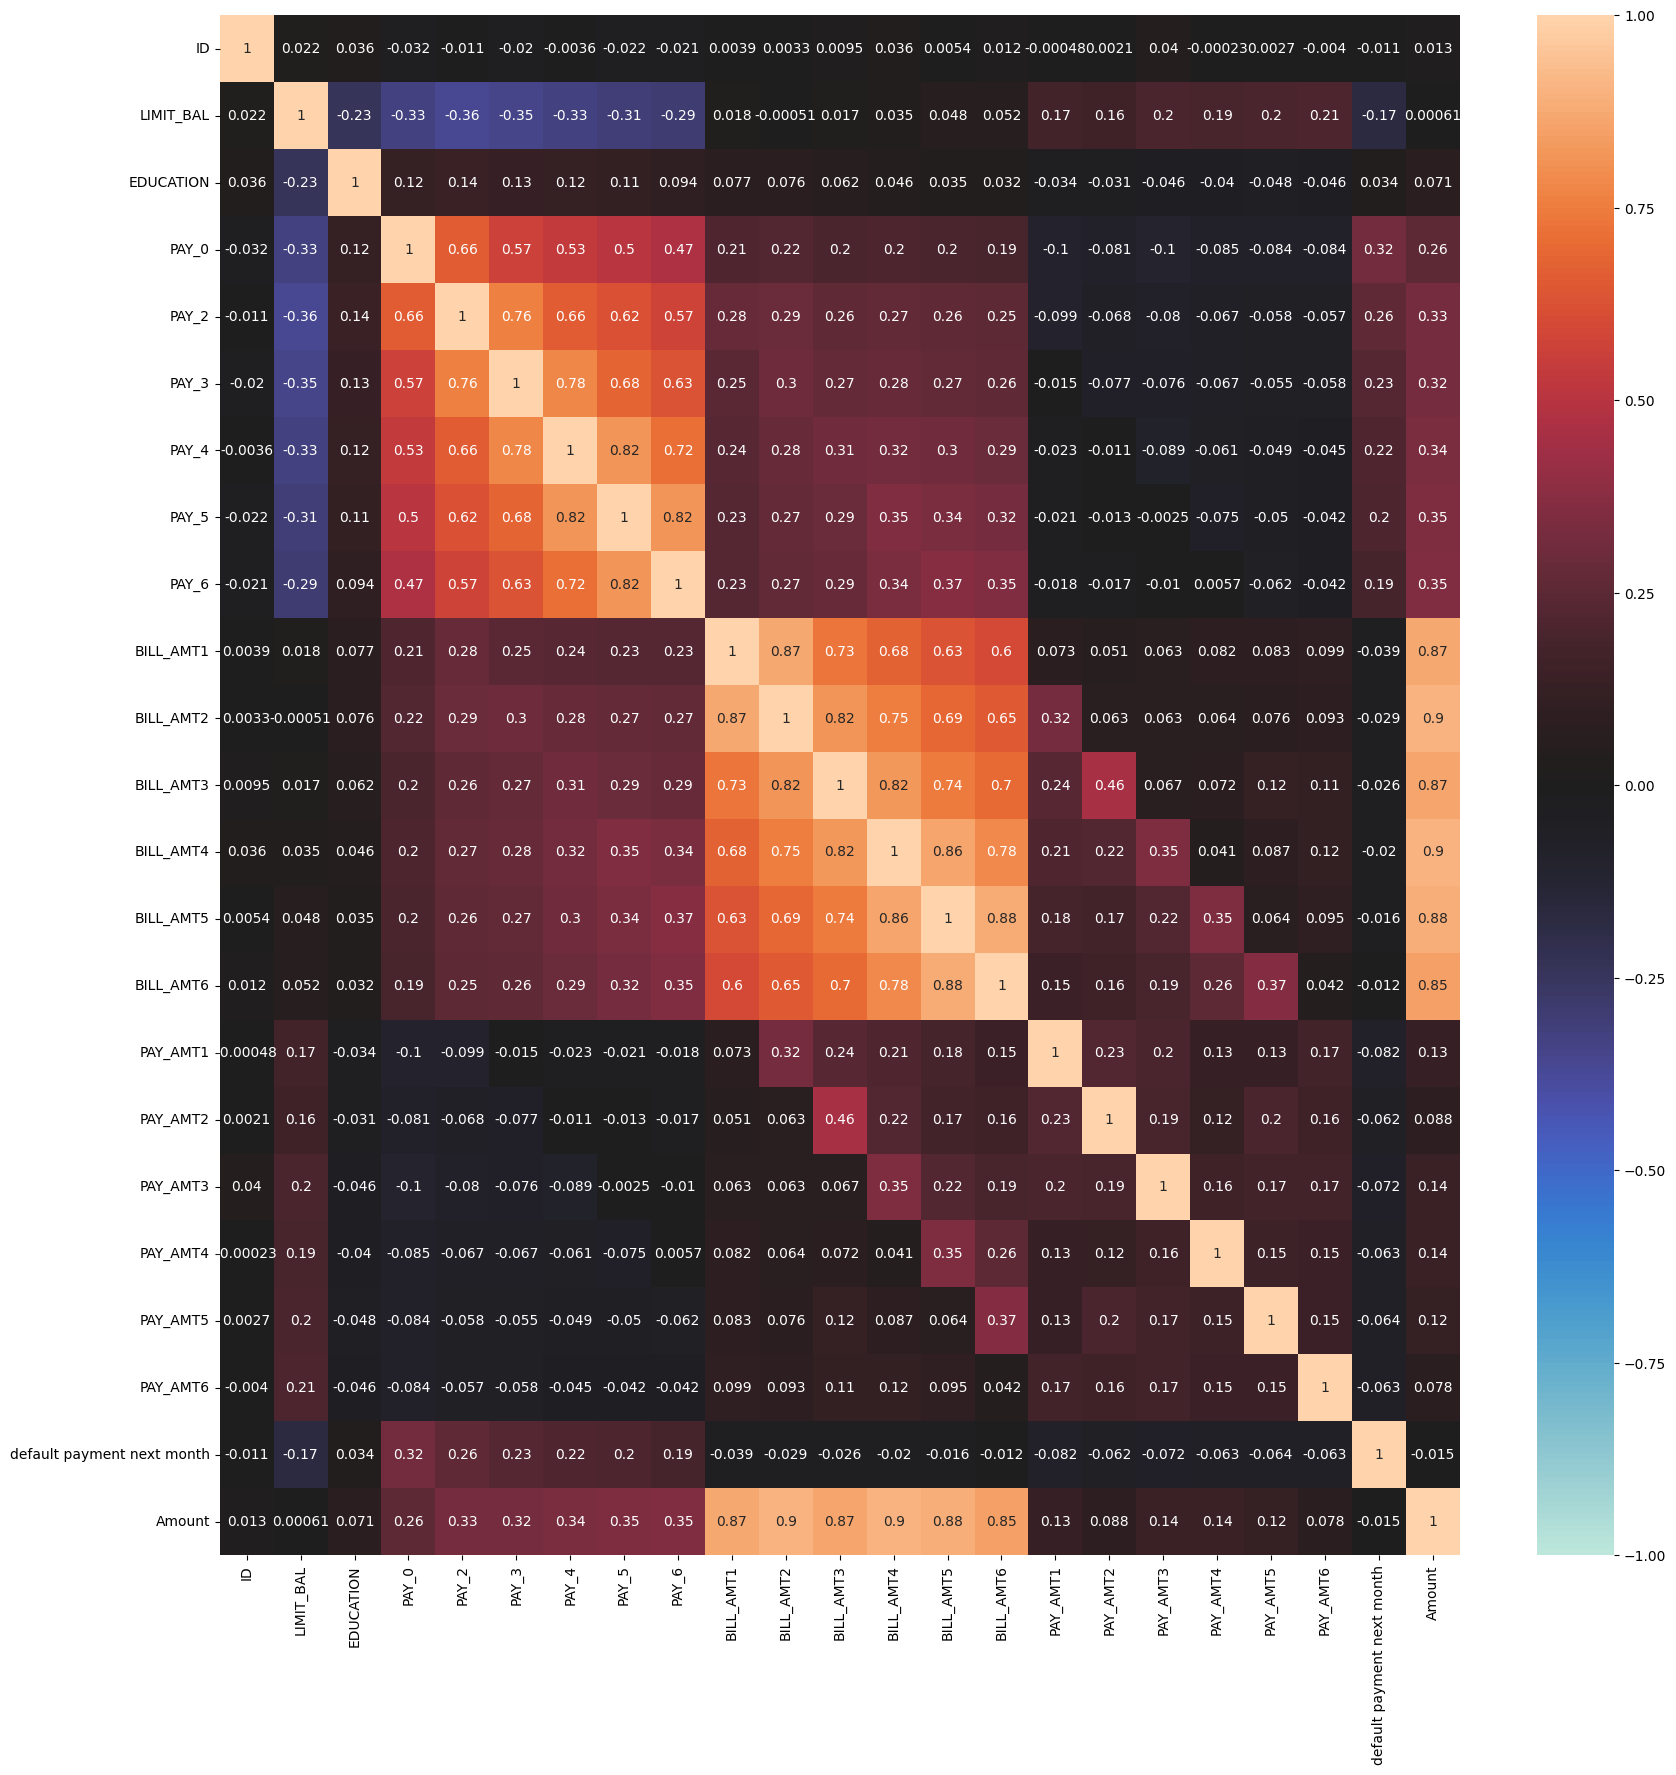

In [ ]:
# Heatmap correlation with only features (X)
df_corr_y = df.copy()
plt.figure(figsize = (20,20))
sns.heatmap(df_corr_y.corr(), vmin=-1, vmax=1, center=0, annot=True)
plt.show()

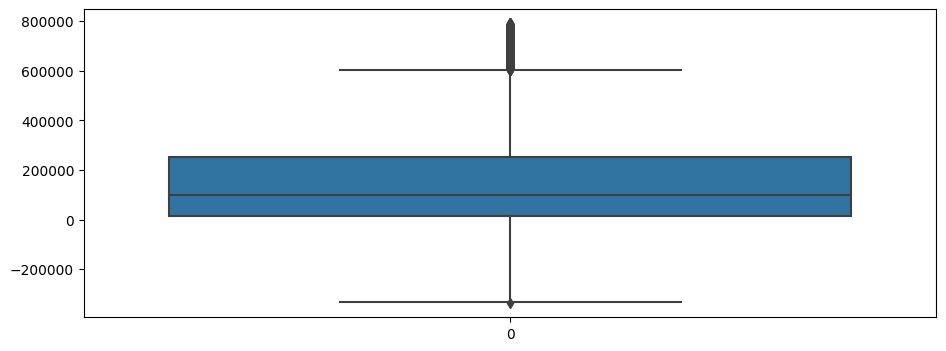

In [ ]:
sns.boxplot(df['Amount'])
plt.show()

In [ ]:
data_X = df.copy()
data_X = data_X.drop(['ID', 'default payment next month'], axis = 1)
data_X.head()

,LIMIT_BAL,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Amount
0,20000,2,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,7015
1,120000,2,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,16077
2,90000,2,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,98635
3,50000,2,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,227315
4,50000,2,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,70658


In [ ]:
data_cat = df[["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]]
data_cat.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0


In [ ]:
data_num = data_X.copy()
data_num = data_num.drop(data_cat.columns, axis = 1)
data_num = data_num.drop('EDUCATION', axis = 1)
data_num = data_num.drop('LIMIT_BAL', axis = 1)
data_num.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Amount
0,3913,3102,689,0,0,0,0,689,0,0,0,0,7015
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,16077
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,98635
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,227315
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,70658


In [ ]:
data_target = df[['default payment next month']]

In [ ]:
#scale on numerical columns--brings the value of each feature into the range of 0 to 1
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
def scaleNum(df_num, cols):
    for col in cols:
        df_num[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(data_num[col])),columns=[col])
    return df_num
data_normal_num = scaleNum(data_num,data_num.columns)
data_normal_num.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Amount
0,0.271431,0.132229,0.086723,0.283019,0.194855,0.443276,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,0.305267
1,0.269459,0.129730,0.087817,0.288466,0.203133,0.447532,0.000000,0.000594,0.002395,0.002012,0.000000,0.003783,0.313297
2,0.311988,0.152050,0.093789,0.306877,0.230667,0.463572,0.003006,0.000891,0.002395,0.002012,0.002345,0.009458,0.386454
3,0.340415,0.214112,0.113407,0.330156,0.264234,0.481843,0.003960,0.001199,0.002874,0.002213,0.002506,0.001892,0.500480
4,0.278964,0.136888,0.106020,0.317880,0.240724,0.468247,0.003960,0.021779,0.023947,0.018109,0.001615,0.001284,0.361663


In [ ]:
# label encoding on categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
def scaleCat(df_cat, cols):
    for col in cols:
        df_cat[col] = pd.DataFrame(label_encoder.fit_transform(pd.DataFrame(data_cat[col])),columns=[col])
    return df_cat
data_normal_cat = scaleCat(data_cat,data_cat.columns)
data_normal_cat.head()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,4,4,1,1,0,0
1,1,4,2,2,2,3
2,2,2,2,2,2,2
3,2,2,2,2,2,2
4,1,2,1,2,2,2


In [ ]:
# perform label encoding on the outcome variable
label_encoder = LabelEncoder()
def scaleCat(df_cat, cols):
    for col in cols:
        df_cat[col] = pd.DataFrame(label_encoder.fit_transform(pd.DataFrame(data_target[col])),columns=[col])
    return df_cat
data_normal_target = scaleCat(data_target,data_target.columns)
data_normal_target.head()

,default payment next month
0,1
1,1
2,0
3,0
4,0


In [ ]:
mapping = {
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}
df['EDUCATION'] = df['EDUCATION'].map(mapping)
df['EDUCATION'].head()

0    university
1    university
2    university
3    university
4    university
Name: EDUCATION, dtype: object

In [ ]:
df_EDUCATION = pd.get_dummies(df['EDUCATION'])
df_EDUCATION.head()

,graduate school,high school,others,university
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [ ]:
df_LIMIT_BAL = np.log1p(df['LIMIT_BAL'])

In [ ]:
# combine preprocessed dataframes
data_fitur = data_normal_num.merge(data_normal_cat, left_index = True, right_index = True)
data_fitur = data_fitur.merge(df_EDUCATION, left_index = True, right_index = True)
data_fitur = data_fitur.merge(df_LIMIT_BAL, left_index = True, right_index = True)
data = data_fitur.merge(data_normal_target, left_index = True, right_index = True)
data.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Amount,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,graduate school,high school,others,university,LIMIT_BAL,default payment next month
0,0.271431,0.132229,0.086723,0.283019,0.194855,0.443276,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,0.305267,4,4,1,1,0,0,0,0,0,1,9.903538,1
1,0.269459,0.129730,0.087817,0.288466,0.203133,0.447532,0.000000,0.000594,0.002395,0.002012,0.000000,0.003783,0.313297,1,4,2,2,2,3,0,0,0,1,11.695255,1
2,0.311988,0.152050,0.093789,0.306877,0.230667,0.463572,0.003006,0.000891,0.002395,0.002012,0.002345,0.009458,0.386454,2,2,2,2,2,2,0,0,0,1,11.407576,0
3,0.340415,0.214112,0.113407,0.330156,0.264234,0.481843,0.003960,0.001199,0.002874,0.002213,0.002506,0.001892,0.500480,2,2,2,2,2,2,0,0,0,1,10.819798,0
4,0.278964,0.136888,0.106020,0.317880,0.240724,0.468247,0.003960,0.021779,0.023947,0.018109,0.001615,0.001284,0.361663,1,2,1,2,2,2,0,0,0,1,10.819798,0


In [ ]:
data['TOTAL_BILL_AMT'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
data['TOTAL_PAY_AMT'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']

data['MEAN_PAY_AMT'] = data['TOTAL_PAY_AMT'] / 6
data['MEAN_BILL_AMT'] = data['TOTAL_BILL_AMT'] / 6


# Ratio of Total Pay/Total Bill, if Total Bill is zero, then take Total Pay; prevent division by zero
data['TOTAL_PAY/TOTAL_BILL'] = np.where(data['TOTAL_BILL_AMT']==0, data['TOTAL_PAY_AMT'], data['TOTAL_PAY_AMT'] / data['TOTAL_BILL_AMT'])

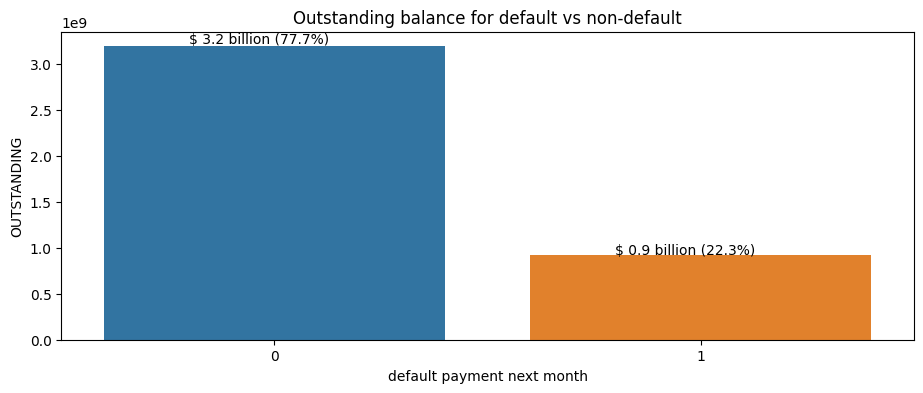

In [ ]:
# Calculate outstanding balance for defaulters and non-defaulters

data['OUTSTANDING'] = data['TOTAL_BILL_AMT'] - data['TOTAL_PAY_AMT']

# group into defaulters and non-defaulters
grp0 = data.groupby('default payment next month').get_group(0)
grp1 = data.groupby('default payment next month').get_group(1)

# Calculate outstanding sum for default and non-default, take only the positives, because some are negative
outstanding0 = grp0.loc[grp0['OUTSTANDING'] >= 0, 'OUTSTANDING'].sum()
outstanding1 = grp1.loc[grp1['OUTSTANDING'] >= 0, 'OUTSTANDING'].sum()


# Calculate percentages
outstanding0_percent = round(outstanding0 / (outstanding0 + outstanding1) * 100,2)
outstanding1_percent = round(outstanding1 / (outstanding0 + outstanding1) * 100,2)

# Plot bar chart
sns.barplot(data=data.groupby('default payment next month')['OUTSTANDING'].sum().reset_index(), x='default payment next month', y='OUTSTANDING');
plt.text(-0.2, outstanding0, f'${outstanding0 / 1e9: .1f} billion ({outstanding0_percent:.1f}%)')
plt.text(0.8, outstanding1, f'${outstanding1 / 1e9: .1f} billion ({outstanding1_percent:.1f}%)');
plt.title('Outstanding balance for default vs non-default');

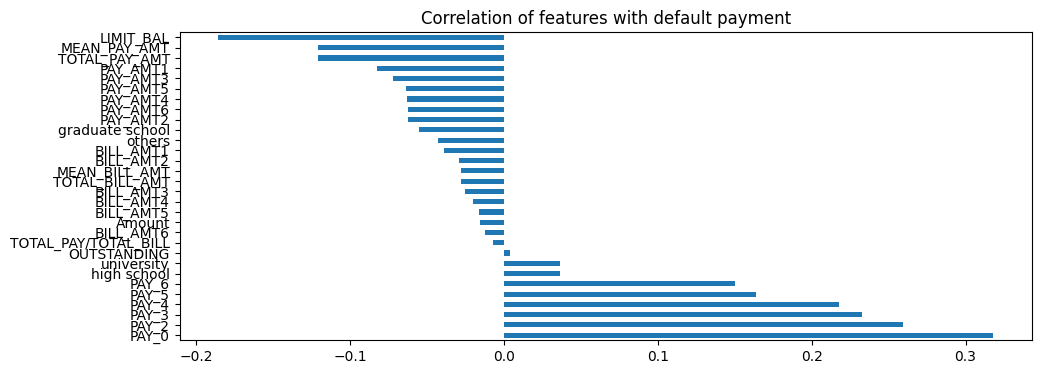

In [ ]:
data.corr()['default payment next month'].sort_values(ascending=False)[1:].plot(kind='barh')
plt.title('Correlation of features with default payment');

# Limit balance, and mean payment amounts have the highest negative correlation with 'default payment this month'.

In [ ]:
cols_to_drop = [
                'MEAN_PAY_AMT', 'MEAN_BILL_AMT', # can drop these for slight increase in ROC for classifiers
                'OUTSTANDING'   # low correlation with default flag
               ]

data = data.drop(columns=cols_to_drop)

In [ ]:
# split a dataset into training and testing subsets
from sklearn.model_selection import train_test_split

x = data.drop(['default payment next month'], axis=1)
y = data["default payment next month"]

X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2, random_state = 45)

In [ ]:
# address class imbalance -- over-sample the minority class in the training data
over = SMOTE(sampling_strategy=0.5)

steps = [
    ('over',over)
]
xs, ys = Pipeline(steps=steps).fit_resample(X_train, y_train)
class_cnt = dict(Counter(ys))
print('The new count of classes:', class_cnt)

The new count of classes: {0: 17063, 1: 8531}


In [ ]:
# Machine learning model 1 training phase (Random Forest classifier gini index)

model_rfgi = RandomForestClassifier(criterion='gini')
model_rfgi.fit(xs, ys)

RandomForestClassifier()

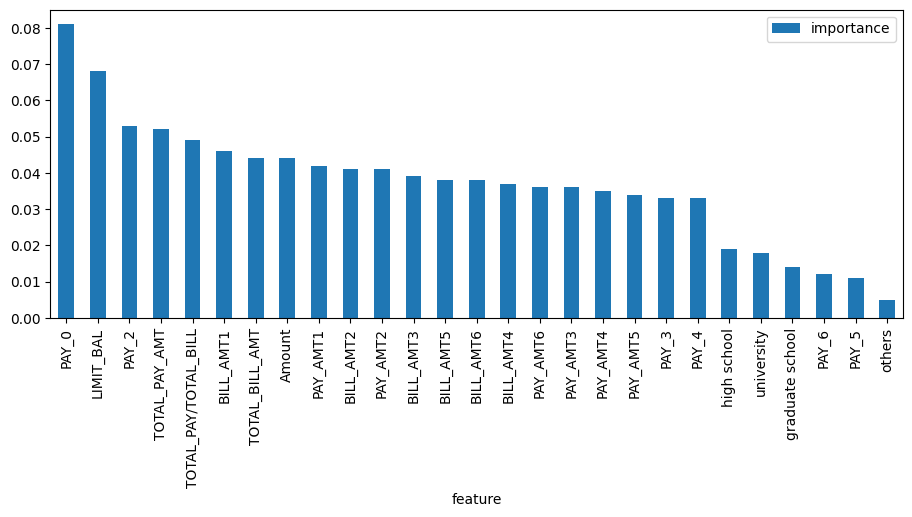

In [ ]:
# feature importance analysis
# extract important features
score = np.round(model_rfgi.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
# Machine learning model 2 training phase (Gradient boosting classifier)

model_gb = GradientBoostingClassifier()
model_gb.fit(xs, ys)

GradientBoostingClassifier()

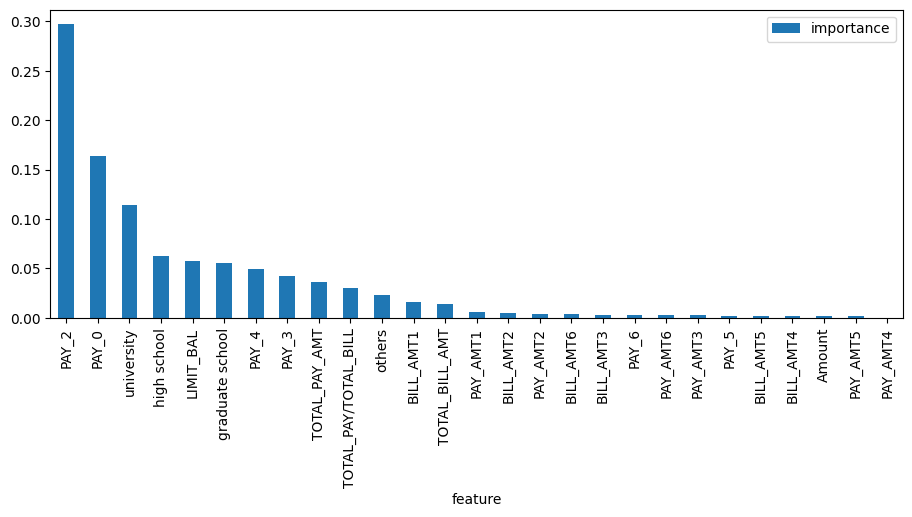

In [ ]:
model_gb.fit(xs, ys);
# extract important features
score = np.round(model_gb.feature_importances_,3)
importances = pd.DataFrame({'feature':xs.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
# Machine learning model 1 testing phase (random forest)

pred_rfgi = model_rfgi.predict(X_test)
pred_rfgi

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
# combine the actual target values with the predicted target values
pd.DataFrame({'Actual':y_test,'RFGI':pred_rfgi})

In [ ]:
# Machine learning model 3 testing phase (gradient boosting)

pred_gb = model_gb.predict(X_test)
pred_gb

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
pd.DataFrame({'actual':y_test,'GB':pred_gb})

In [ ]:
# concatenate the training and testing data along with their corresponding labels
X = xs.append(X_test)
y = ys.append(y_test)

In [ ]:
# convert the data to a NumPy array
X = X.values
y = y.values

In [ ]:
# Machine learning model 1 optimization phase (randomized search for random forest)

rfgi_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
n_iter_search = 20
random_search = RandomizedSearchCV(model_rfgi, rfgi_tuned_params,
                                   n_iter = n_iter_search, cv=10)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_rfgi = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4} 

0.751 (+/-0.007) for {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4}
0.724 (+/-0.016) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 4}
0.724 (+/-0.023) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 5}
0.751 (+/-0.008) for {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 4}
0.719 (+/-0.027) for {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 4}
0.744 (+/-0.012) for {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.751 (+/-0.008) for {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 7}
0.721 (+/-0.023) for {'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 5}
0.719 (+/-0.027) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 3}
0.752 (+/-0.010) for {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4}
0.725 (+/-0.021) for {'max_depth': 1, 'min_samples_leaf': 5, 'min_sa

In [ ]:
# initialize the classifier with the optimized parameters
model_rfgi2 = RandomForestClassifier(criterion='gini', max_depth= best_rfgi['max_depth'], min_samples_leaf= best_rfgi['min_samples_leaf'], min_samples_split= best_rfgi['min_samples_split'])

In [ ]:
model_rfgi2.fit(xs, ys)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=4)

In [ ]:
model_rfgi2.predict(X_test)
model_rfgi2.score(X_test,y_test)

0.8044112285818447

In [ ]:
# Machine learning model 2 optimization phase (randomized search for gradient boosting)

gb_tuned_params = {   "max_depth": sp_randint(1, 4),
                      "min_samples_leaf"  : sp_randint(2, 11),
                      'min_samples_split' : sp_randint(2, 11)}
# you can change it
n_iter_search = 20
random_search = RandomizedSearchCV(model_gb, gb_tuned_params,
                                   n_iter = n_iter_search, cv=5)

random_search.fit(X, y)
print("Best Params : ",random_search.best_params_,"\n")
best_gb = random_search.best_params_

means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, random_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best Params :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10} 

0.788 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}
0.807 (+/-0.083) for {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.807 (+/-0.084) for {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.788 (+/-0.043) for {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 5}
0.807 (+/-0.083) for {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 9}
0.788 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.759 (+/-0.013) for {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 7}
0.759 (+/-0.013) for {'max_depth': 1, 'min_samples_leaf': 7, 'min_samples_split': 8}
0.759 (+/-0.013) for {'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 3}
0.807 (+/-0.084) for {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 9}
0.759 (+/-0.013) for {'max_depth': 1, 'min_samples_leaf': 3, 'min_

In [ ]:
model_gb2 = GradientBoostingClassifier(max_depth= best_gb["max_depth"], min_samples_leaf= best_gb["min_samples_leaf"], min_samples_split= best_gb["min_samples_split"])

In [ ]:
model_gb2.fit(xs, ys)

GradientBoostingClassifier(min_samples_leaf=5, min_samples_split=10)

In [ ]:
model_gb2.score(X_test,y_test)

0.8197229310973386

In [ ]:
# plot the ROC curve for a certain classifier
def fig_roc(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probability estimates for positive class
    fp,tp,thresholds=roc_curve(y_test, y_scores, pos_label=1)
    AUC=auc(fp,tp)*100
    plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
    t=str(clf)
    plt.title('Receiver Operating Characteristic'+t)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

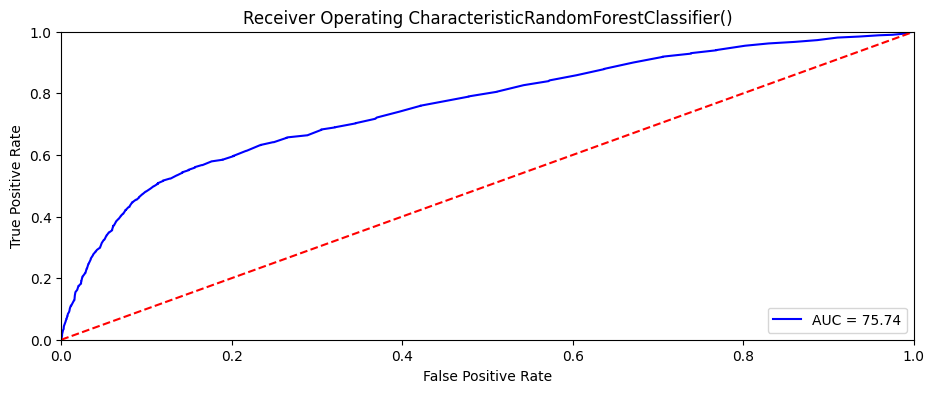

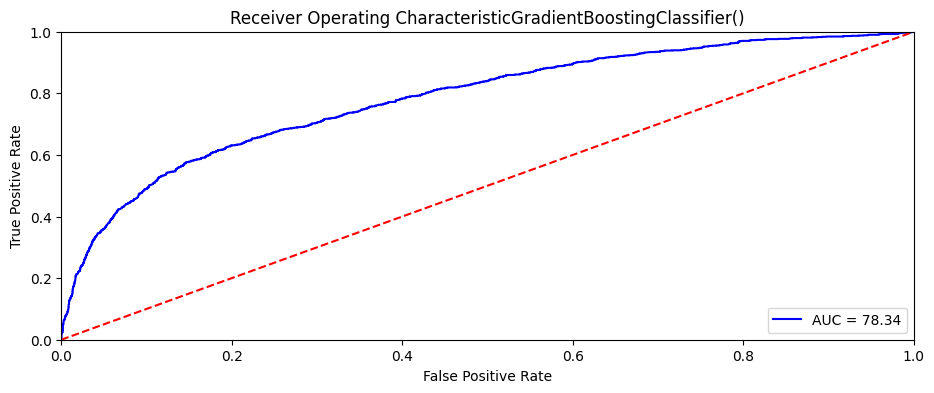

In [ ]:
fig_roc(model_rfgi,xs, X_test, ys, y_test)
fig_roc(model_gb,xs, X_test, ys, y_test)

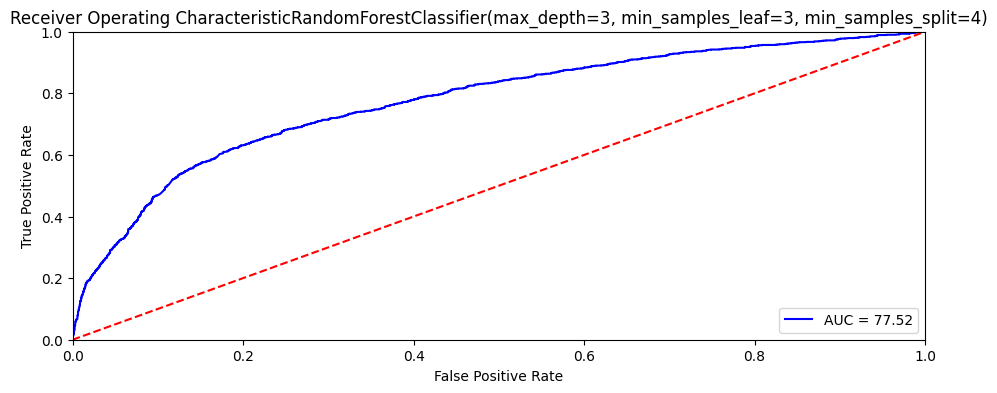

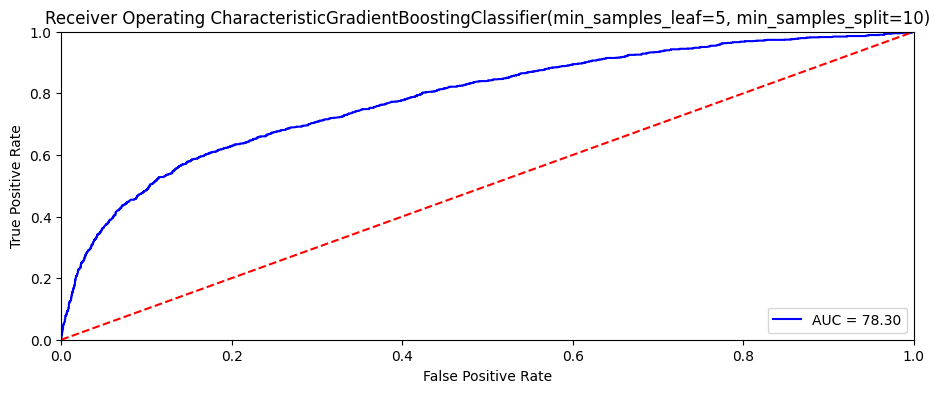

In [ ]:
fig_roc(model_rfgi2,xs, X_test, ys, y_test)
fig_roc(model_gb2,xs, X_test, ys, y_test)

In [ ]:
# Model analysis

print("Random Forest Gini Index")
print("Accuracy : ", model_rfgi.score(X_test,y_test)*100,"%\n")

print("Gradient Boosting")
print("Accuracy : ", model_gb.score(X_test,y_test)*100,"%\n")

modscore = [model_rfgi.score(X_test,y_test),\
           model_gb.score(X_test,y_test)]
maxim = max(modscore)
model = ["Random Forest Gini Index","Gradient Boosting"]

print("The best performing model before optimization is ",model[modscore.index(maxim)]," with accuracy ", maxim*100,"%\n")

Random Forest Gini Index
Accuracy :  81.33430550492162 %

Gradient Boosting
Accuracy :  82.00874954429457 %

The best performing model before optimization is  Gradient Boosting  with accuracy  82.00874954429457 %



In [ ]:
# Result after optimization phase

print("Random Forest Gini Index")
print("Accuracy : ", model_rfgi2.score(X_test,y_test)*100,"%\n")

print("Gradient Boosting")
print("Accuracy : ", model_gb2.score(X_test,y_test)*100,"%\n")

modscore2 = [model_rfgi2.score(X_test,y_test),\
           model_gb2.score(X_test,y_test)]
maxim2 = max(modscore2)
model = ["Random Forest Gini Index","Gradient Boosting"]

print("The model with the best results after optimization is ",model[modscore2.index(maxim2)]," with accuracy ", maxim2*100,"%\n")

Random Forest Gini Index
Accuracy :  80.64163324826832 %

Gradient Boosting
Accuracy :  81.99052132701422 %

The model with the best results after optimization is  Gradient Boosting  with accuracy  81.99052132701422 %



In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

In [ ]:
input_size = 27

model.add(Dense(input_size, activation='relu'))
model.add(Dense(27, activation='relu'))

model.add(Dense(14, activation='relu'))
model.add(Dense(7, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 10
max_epochs = 1000
early =EarlyStopping(patience=50)

In [ ]:
X_train2, X_valid, y_train2, y_valid = train_test_split(xs, ys, train_size=(8/9), random_state=42)

In [ ]:
model.fit(X_train2, y_train2, batch_size=batch_size, epochs=max_epochs, callbacks=[early], validation_data=(X_valid, y_valid), verbose=2)

In [ ]:
predictions = model.predict(X_train2)

# Convert the predicted probabilities to class labels
predmodel = np.argmax(predictions, axis=1)

711/711 [==============================] - 1s 842us/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_train2, predmodel))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     15156
           1       0.00      0.00      0.00      7594

    accuracy                           0.67     22750
   macro avg       0.33      0.50      0.40     22750
weighted avg       0.44      0.67      0.53     22750



In [ ]:
predictions1 = model.predict(X_valid)

# Convert the predicted probabilities to class labels
predvalid = np.argmax(predictions1, axis=1)

89/89 [==============================] - 0s 913us/step


In [ ]:
print(classification_report(y_valid, predvalid))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1907
           1       0.00      0.00      0.00       937

    accuracy                           0.67      2844
   macro avg       0.34      0.50      0.40      2844
weighted avg       0.45      0.67      0.54      2844



In [ ]:
predictions2 = model.predict(X_test)

# Convert the predicted probabilities to class labels
predtest = np.argmax(predictions2, axis=1)

172/172 [==============================] - 0s 868us/step


In [ ]:
print(classification_report(y_test, predtest))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4276
           1       0.00      0.00      0.00      1210

    accuracy                           0.78      5486
   macro avg       0.39      0.50      0.44      5486
weighted avg       0.61      0.78      0.68      5486



In [ ]:
predtrainrf = model_rfgi2.predict(X_train2)
predvalrf = model_rfgi2.predict(X_valid)
predtestrf = model_rfgi2.predict(X_test)

In [ ]:
print(classification_report(y_test, predtestrf))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4276
           1       0.60      0.36      0.45      1210

    accuracy                           0.81      5486
   macro avg       0.72      0.65      0.67      5486
weighted avg       0.79      0.81      0.79      5486



In [ ]:
print(classification_report(y_valid, predvalrf))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1907
           1       0.70      0.33      0.45       937

    accuracy                           0.73      2844
   macro avg       0.72      0.63      0.64      2844
weighted avg       0.73      0.73      0.70      2844



In [ ]:
print(classification_report(y_train2, predtrainrf))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83     15156
           1       0.73      0.36      0.49      7594

    accuracy                           0.74     22750
   macro avg       0.74      0.65      0.66     22750
weighted avg       0.74      0.74      0.71     22750



In [ ]:
predtraingb = model_gb2.predict(X_train2)
predvalgb = model_gb2.predict(X_valid)
predtestgb = model_gb2.predict(X_test)

In [ ]:
print(classification_report(y_train2, predtraingb))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     15156
           1       0.82      0.57      0.67      7594

    accuracy                           0.81     22750
   macro avg       0.82      0.75      0.77     22750
weighted avg       0.82      0.81      0.80     22750



In [ ]:
print(classification_report(y_valid, predvalgb))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1907
           1       0.81      0.55      0.66       937

    accuracy                           0.81      2844
   macro avg       0.81      0.74      0.76      2844
weighted avg       0.81      0.81      0.80      2844



In [ ]:
print(classification_report(y_test, predtestgb))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4276
           1       0.65      0.40      0.49      1210

    accuracy                           0.82      5486
   macro avg       0.75      0.67      0.69      5486
weighted avg       0.80      0.82      0.80      5486



In [ ]:
data['PAY_1 || PAY_2'] = ((df['PAY_0'] == -1) | (df['PAY_2'] == -1)).astype(int)
data['PAY_1 & PAY_2'] = ((df['PAY_0'] == -1) & (df['PAY_2'] == -1)).astype(int)
data['default payment next month'] = df['default payment next month']
data.head()

,PAY_1 || PAY_2,PAY_1 & PAY_2,default payment next month
0,0,0,1
1,1,0,1
2,0,0,0
3,0,0,0
4,1,0,0


**Is default affected by PAY1 and PAY2 result?**

In [ ]:
alpha = 0.05
lb, ub = (alpha / 2), 1 - (alpha / 2)
ci_bounds = [lb, ub]

In [ ]:
from scipy import stats

ttest, pval = stats.ttest_ind(data[data['PAY_1 || PAY_2'] == 1]['default payment next month'], data[data['PAY_1 || PAY_2'] == 0]['default payment next month'], equal_var=False)

In [ ]:
print(pval)

if pval < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is accepted.")

5.114445880063805e-36
The null hypothesis is rejected.


In [ ]:
ttest1, pval1 = stats.ttest_ind(data[data['PAY_1 & PAY_2'] == 1]['default payment next month'], data[data['PAY_1 & PAY_2'] == 0]['default payment next month'], equal_var=False)

In [ ]:
print(pval1)

if pval1 < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is accepted.")

3.0393383508008756e-44
The null hypothesis is rejected.


In [ ]:
data = data.drop('Amount', axis = 1)
data.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,graduate school,high school,others,university,LIMIT_BAL,default payment next month,TOTAL_BILL_AMT,TOTAL_PAY_AMT,TOTAL_PAY/TOTAL_BILL,PAY_1 || PAY_2,PAY_1 & PAY_2
0,0.271431,0.132229,0.086723,0.283019,0.194855,0.443276,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,4,4,1,1,0,0,0,0,0,1,9.903538,1,7704,689,0.089434,0,0
1,0.269459,0.129730,0.087817,0.288466,0.203133,0.447532,0.000000,0.000594,0.002395,0.002012,0.000000,0.003783,1,4,2,2,2,3,0,0,0,1,11.695255,1,17077,5000,0.292791,1,0
2,0.311988,0.152050,0.093789,0.306877,0.230667,0.463572,0.003006,0.000891,0.002395,0.002012,0.002345,0.009458,2,2,2,2,2,2,0,0,0,1,11.407576,0,101653,11018,0.108388,0,0
3,0.340415,0.214112,0.113407,0.330156,0.264234,0.481843,0.003960,0.001199,0.002874,0.002213,0.002506,0.001892,2,2,2,2,2,2,0,0,0,1,10.819798,0,231334,8388,0.036259,0,0
4,0.278964,0.136888,0.106020,0.317880,0.240724,0.468247,0.003960,0.021779,0.023947,0.018109,0.001615,0.001284,1,2,1,2,2,2,0,0,0,1,10.819798,0,109339,59049,0.540054,1,0


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB,ComplementNB

categorical_variables = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','graduate school','high school','others',
                         'university','PAY_1 || PAY_2','PAY_1 & PAY_2']
continuous_variables = ['LIMIT_BAL', 'TOTAL_BILL_AMT','TOTAL_PAY_AMT','TOTAL_PAY/TOTAL_BILL',
                        'BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                        'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

gnb_params = {'var_smoothing':[1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1,
                                        1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]}
cnb_params = {'alpha':[1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,1,
                       1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9] ,
             'fit_prior': [True, False],
             'norm':[True,False]}

def fit_model(model, input_var,params):
    input_var += ['default payment next month',]
    data1 = data[input_var]

    input_variables = data1[data1.columns[:-1]].copy()
    target_variable = data1[data1.columns[-1]].copy()

    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1, cv = 10, scoring= 'roc_auc')

    # fit the model - we will use the entire dataset to train the model
    # because we will be using the predicted values as the features of our combined model
    model1.fit(input_variables, target_variable)
    print("Best Hyper Parameters:\n",model1.best_params_)

    #get the probabilities
    predict_probabilities = model1.predict_proba(input_variables)
    return predict_probabilities

gnb_prob = fit_model(GaussianNB(), continuous_variables,gnb_params)
cnb_prob = fit_model(ComplementNB(), categorical_variables,cnb_params)
gnb_prob_df = pd.DataFrame(gnb_prob)
cnb_prob_df = pd.DataFrame(cnb_prob)
y_series = pd.Series(y)

#make the new dataframe with the probabilities as the new features
new_df = pd.concat([gnb_prob_df, cnb_prob_df, y_series], axis=1)

Best Hyper Parameters:
 {'var_smoothing': 1e-09}
Best Hyper Parameters:
 {'alpha': 1, 'fit_prior': True, 'norm': True}


In [ ]:
new_df = new_df.iloc[:27427]

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss,roc_auc_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report
from sklearn.metrics import balanced_accuracy_score

def get_results(model, y_test, y_pred):
    roc=roc_auc_score(y_test, y_pred, average = 'weighted')
    acc = balanced_accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    rec = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

    model_results = pd.DataFrame([[acc,prec,rec, f1,roc]],
                   columns = ['Balanced Accuracy', 'Weighted Precision',
                              'Weighted Recall', 'Weighted F1 Score','Weighted ROC'])

    return model_results

def make_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cm, annot = True, square = True, fmt = "d", cmap = 'RdPu', vmin = 0, vmax = 20000)
    plt.title("Confusion Matrix", fontsize = 15)
    plt.xlabel('predicted')
    plt.ylabel('target')
    return ax

Best Hyper Parameters:
 {'var_smoothing': 1e-09}
Best Hyper Parameters:
 {'var_smoothing': 1e-09}
Best Hyper Parameters:
 {'var_smoothing': 1e-09}
Best Hyper Parameters:
 {'var_smoothing': 1e-09}
Best Hyper Parameters:
 {'var_smoothing': 1e-09}


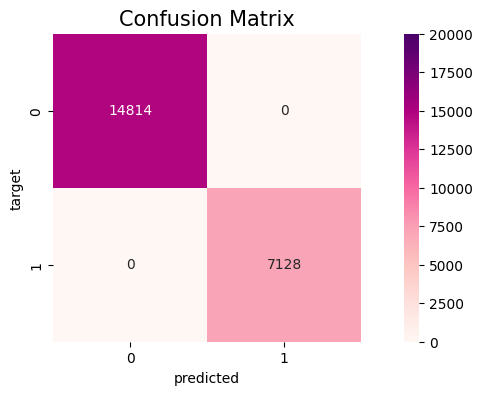

,Balanced Accuracy,Weighted Precision,Weighted Recall,Weighted F1 Score,Weighted ROC
average,1.0,1.0,1.0,1.0,1.0
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0


In [ ]:
from sklearn.model_selection import KFold

gnb = GaussianNB()

input_variables = new_df[new_df.columns[:-1]].copy()
target_variable = new_df[new_df.columns[-1]].copy()

#perform k-fold cross validation
#n_splits is set to 3 because the test set is 1/5 of entire data
#shuffle is set to True because we sorted the data previously. This is to reduce the bias due to a certain feature.
kfold = KFold(n_splits = 5, shuffle = True, random_state = 123)

results = pd.DataFrame(columns = ['Balanced Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score','Weighted ROC'])
scores = []
for test_index,train_index in kfold.split(new_df):
    X_train, X_test, y_train, y_test = (input_variables.iloc[train_index], input_variables.iloc[test_index],
                                        target_variable.iloc[train_index].iloc[:, 2], target_variable.iloc[test_index].iloc[:, 2])

    gnb1 = GridSearchCV(gnb, param_grid=gnb_params, n_jobs=-1, cv = 10, scoring= 'roc_auc')
    gnb1.fit(X_train, y_train)


    print("Best Hyper Parameters:\n",gnb1.best_params_)
    y_pred = gnb1.predict(X_test)

    results = results.append(get_results(gnb1, y_test, y_pred), sort = False,ignore_index = True)


average = pd.DataFrame(data = [[results["Balanced Accuracy"].mean(), results['Weighted Precision'].mean(),
                                results['Weighted Recall'].mean(), results['Weighted F1 Score'].mean(),
                                results['Weighted ROC'].mean()]],
                       columns = ['Balanced Accuracy', 'Weighted Precision',
                                  'Weighted Recall', 'Weighted F1 Score','Weighted ROC'],
                       index = ['average'])
results = average.append(results)

make_confusion_matrix(y_test, y_pred)
plt.show()

results

In [ ]:
data['ID'] = df['ID']

In [ ]:
# Use model to predict customers default probabilities on X_test
predict_proba = model_gb2.predict_proba(X_test)

# We will be using X_test subset of the original df for cluster segmentation
default_df = data.iloc[X_test.index]

# Add true labels back to default_df for clustering evaluation later
default_df['default payment next month'] = y_test

default_df['DEFAULT_PROB'] = predict_proba[:,1] # get class 1 probabilities

# Outstanding amount
default_df['OUTSTANDING'] = default_df['TOTAL_BILL_AMT'] - default_df['TOTAL_PAY_AMT']


# Importance of defaulting = Outstanding * Default Probability
default_df['DEFAULT_IMPORTANCE'] = round(default_df['OUTSTANDING'] * default_df['DEFAULT_PROB'], 2)

# Sort users by Default Importance
default_df.sort_values(by='DEFAULT_IMPORTANCE', ascending=False)[['DEFAULT_IMPORTANCE']].head(20)

# Top 20 customers sorted based on default importance

,DEFAULT_IMPORTANCE
27184,586727.06
10162,577702.14
13143,575829.59
15521,567136.90
16235,561008.04
26478,551598.07
21122,548416.88
13843,542608.63
18856,534547.83
1570,534004.72


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.21, 0.5, '50% of defaulters')

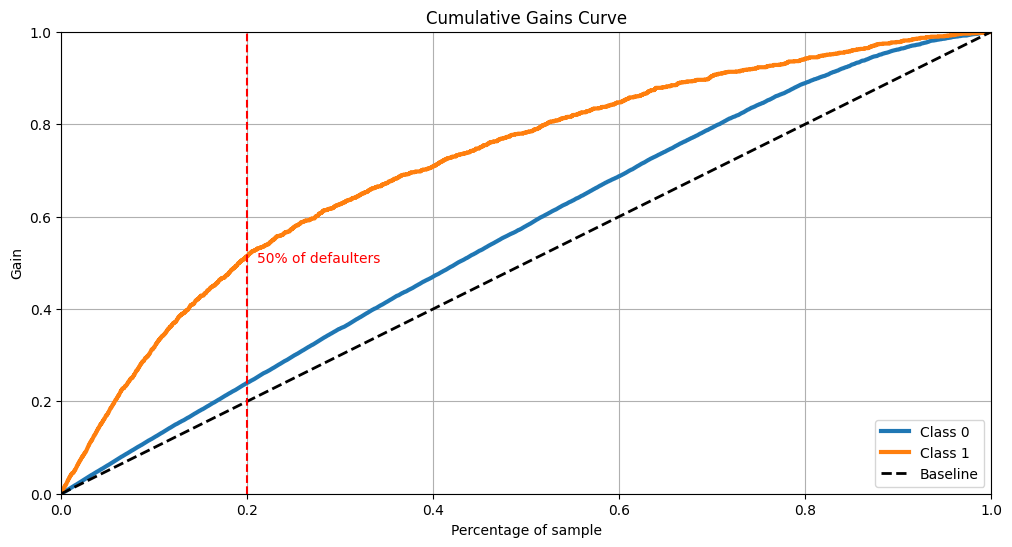

In [ ]:
! pip install scikit-plot
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

plot_cumulative_gain(y_test, predict_proba, figsize=(12,6));

plt.axvline(x=0.2, color='r', linestyle='--')
plt.text(0.21, 0.50, '50% of defaulters', color='r')

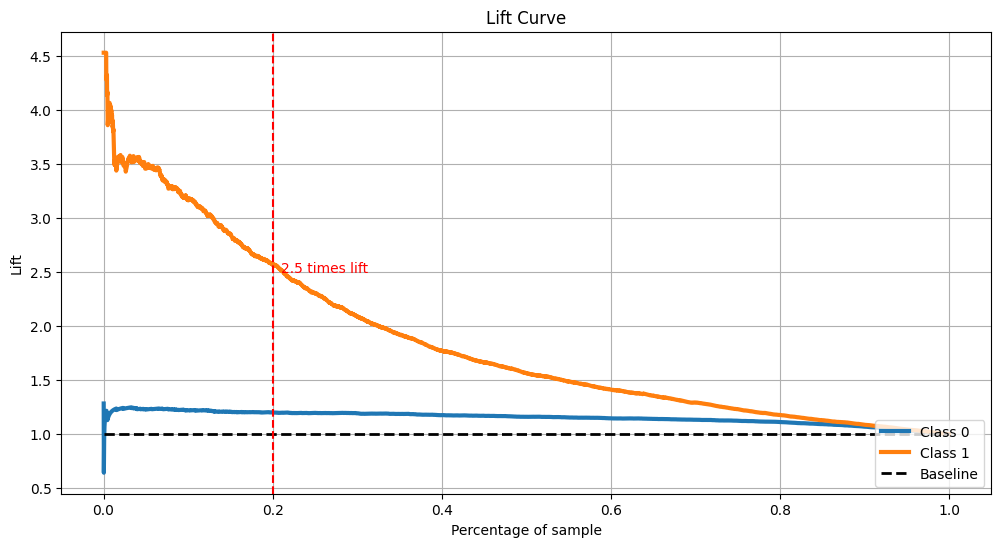

In [ ]:
plot_lift_curve(y_test, predict_proba, figsize=(12,6))

plt.axvline(x=0.2, color='r', linestyle='--')
plt.text(0.21, 2.5, '2.5 times lift', color='r');

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

In [ ]:
default_df.describe()[['DEFAULT_PROB', 'DEFAULT_IMPORTANCE']]

# The top 25% for default probability is above 0.36

,DEFAULT_PROB,DEFAULT_IMPORTANCE
count,5486.000000,5486.000000
mean,0.284487,42624.536280
std,0.198734,71261.736331
min,0.039816,-45325.850000
25%,0.140431,733.687500
50%,0.215569,18108.450000
75%,0.370383,54900.987500
max,0.899954,586727.060000


Text(0.5, 1.0, 'Scatterplot of Default Probability and Outstanding Amt')

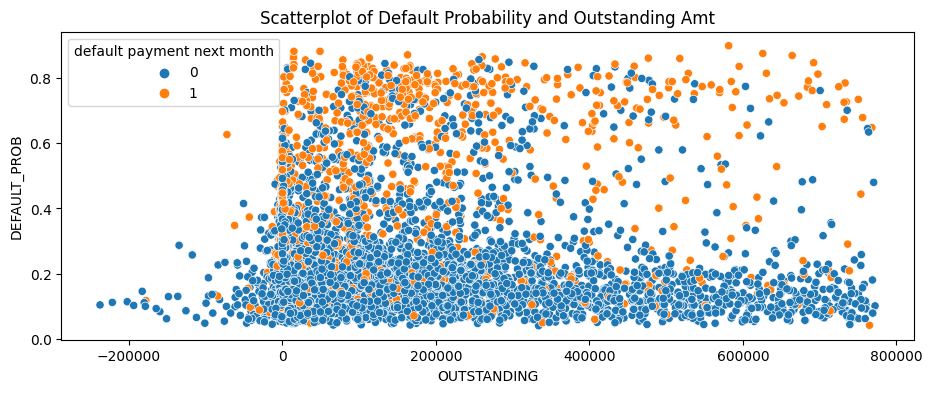

In [ ]:
sns.scatterplot(data=default_df, x='OUTSTANDING', y='DEFAULT_PROB', hue='default payment next month')

plt.title('Scatterplot of Default Probability and Outstanding Amt')

In [ ]:
cols_for_clustering = [
                    'DEFAULT_IMPORTANCE', # = Default Proba * Outstanding
                    'LIMIT_BAL'
                      ]

cluster_df = default_df[cols_for_clustering]

cluster_df.head()

,DEFAULT_IMPORTANCE,LIMIT_BAL
21160,-3395.62,0.113924
22214,22569.65,0.126582
7781,68816.73,0.025316
10330,17336.90,0.000000
20313,15241.19,0.177215


In [ ]:
# Scaling / Standardization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = cluster_df.columns

# Scale the columns
cluster_df_scaled = cluster_df.copy()
cluster_df_scaled[cols_to_scale] = scaler.fit_transform(cluster_df[cols_to_scale])

# Assign weights to columns
weights = np.array([4, 1]) # Weightage affects silhouette score of clusters and collected sum

cluster_df_scaled = cluster_df_scaled * weights

In [ ]:
cluster_df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
DEFAULT_IMPORTANCE,5486.0,0.556601,0.450986,0.0,0.291492,0.401449,0.634294,4.0
LIMIT_BAL,5486.0,0.185889,0.158762,0.0,0.050633,0.139241,0.265823,1.0


Text(0.5, 1.0, 'Elbow plot of Kmeans clusters')

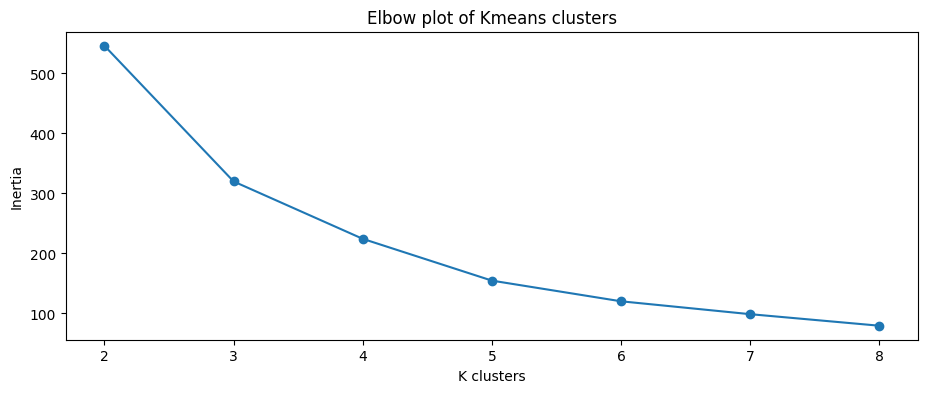

In [ ]:
# Find the optimum clusters using an elbow plot

errors = {}
silhouette_scores = {}

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cluster_df_scaled)
    errors[k] = kmeans.inertia_
    y_pred = kmeans.predict(cluster_df_scaled)
    silhouette_scores[k] = silhouette_score(cluster_df_scaled, y_pred)

plt.plot(errors.keys(), errors.values(), marker='o')
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot of Kmeans clusters')

Text(0.5, 1.0, 'Plot of Silhouette scores for K clusters')

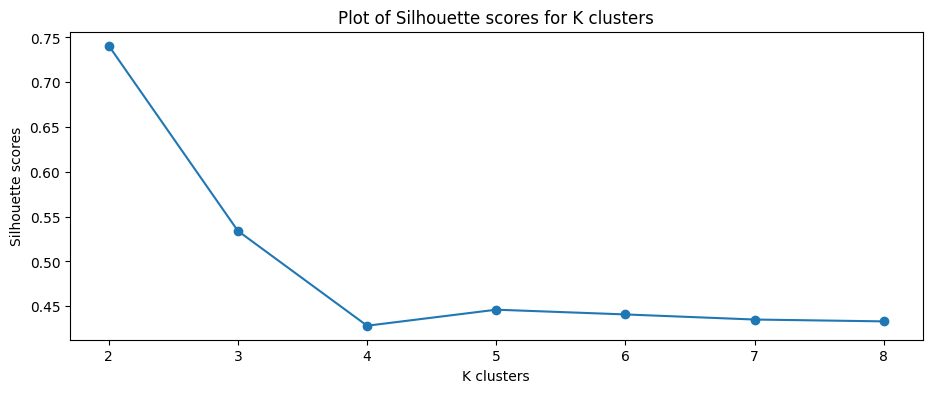

In [ ]:
plt.plot(silhouette_scores.keys(), silhouette_scores.values() , marker='o');
plt.xlabel('K clusters')
plt.ylabel('Silhouette scores')
plt.title('Plot of Silhouette scores for K clusters')

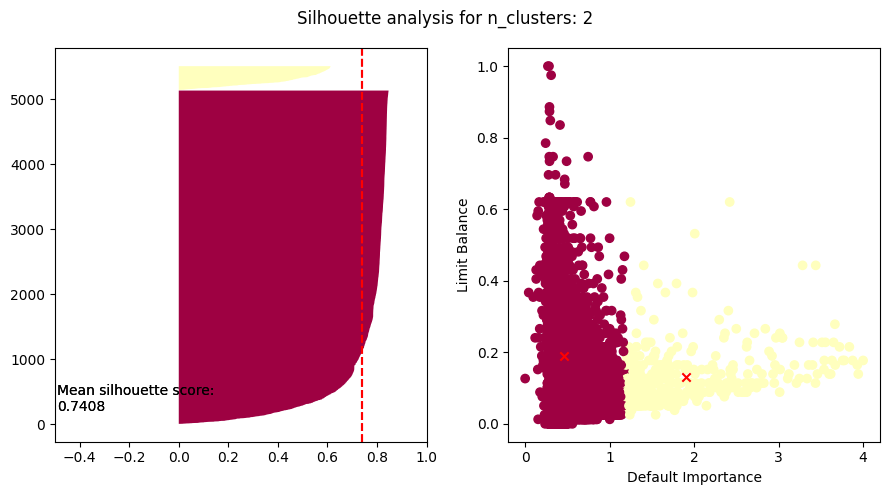

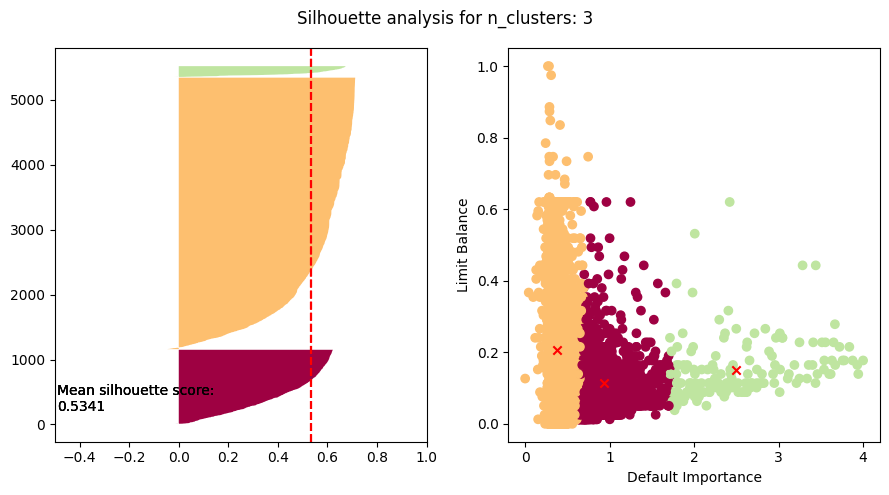

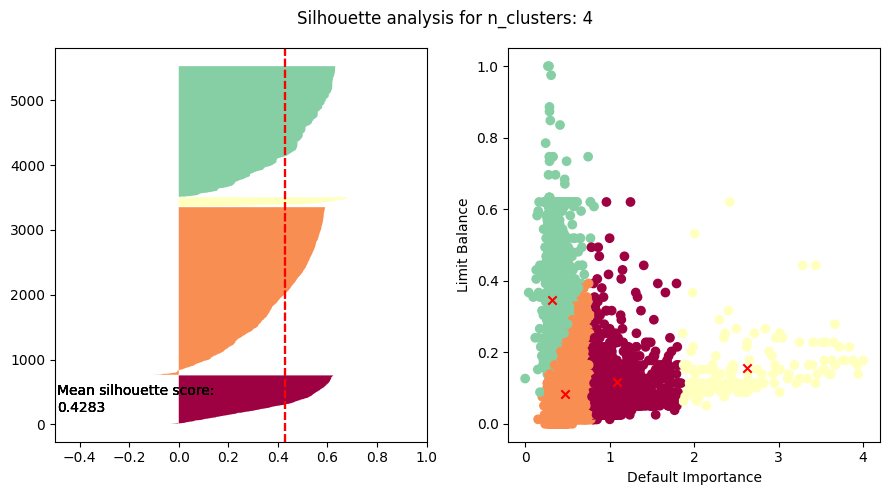

In [ ]:
for k in range(2,5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cluster_df_scaled)
    labels = kmeans.predict(cluster_df_scaled)
    centroids = kmeans.cluster_centers_

    sil_samp = silhouette_samples(cluster_df_scaled, labels)
    sil_overall = silhouette_score(cluster_df_scaled, labels)

    y_lower = 10

    plt.figure(figsize=(9,5))
    plt.suptitle(f'Silhouette analysis for n_clusters: {k}')

    # for each cluster in total K clusters
    for n in range(k):

        # get coeff scores for the n cluster
        sil_coeff = sil_samp[labels == n]
        sil_coeff.sort() # sort for small to large
        y_upper = y_lower + len(sil_coeff)

        # get number of points in that cluster
        y_points = np.linspace(y_lower, y_upper, len(sil_coeff))


        plt.subplot(1, 2, 1)
        plt.xlim(-.5, 1)
        plt.annotate(f'Mean silhouette score: \n' + str(sil_overall.round(4)), (-0.49, 200))

        cmap = plt.get_cmap("Spectral")
        color = cmap(float(n)/k)
        plt.fill_betweenx(y_points, sil_coeff, facecolor=color)
        plt.axvline(x = sil_overall, linestyle='--', c='r')

        y_lower = y_upper + 10 # set the lower limit for the next cluster

    plt.subplot(1, 2, 2)
    colors = cmap(labels.astype(float)/k)
    plt.scatter(cluster_df_scaled.iloc[:,0], cluster_df_scaled.iloc[:,1], c=colors)
    plt.xlabel('Default Importance')
    plt.ylabel('Limit Balance')

    # plot the cluster centers
    plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);
    plt.tight_layout()

Based on the plots above, I'm leaning towards 4 clusters because it can capture a larger grouping of high default importance users, compared to other clusters.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(cluster_df_scaled)
print('Kmeans silhouette score:', silhouette_score(cluster_df_scaled, y_pred))

agglo = AgglomerativeClustering(n_clusters=4)
y_pred2 = agglo.fit_predict(cluster_df_scaled)
print('Agglomerative silhouette score:', silhouette_score(cluster_df_scaled, y_pred2))

Kmeans silhouette score: 0.4283310643581614
Agglomerative silhouette score: 0.4318314197806954


In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(cluster_df_scaled)

default_df['SEGMENT'] = labels


Highest default importance segment: SEGMENT 2
Size of segment: 2.5701786365293473 %
Features used for clustering: ['DEFAULT_IMPORTANCE', 'LIMIT_BAL']
Weights: [4 1]


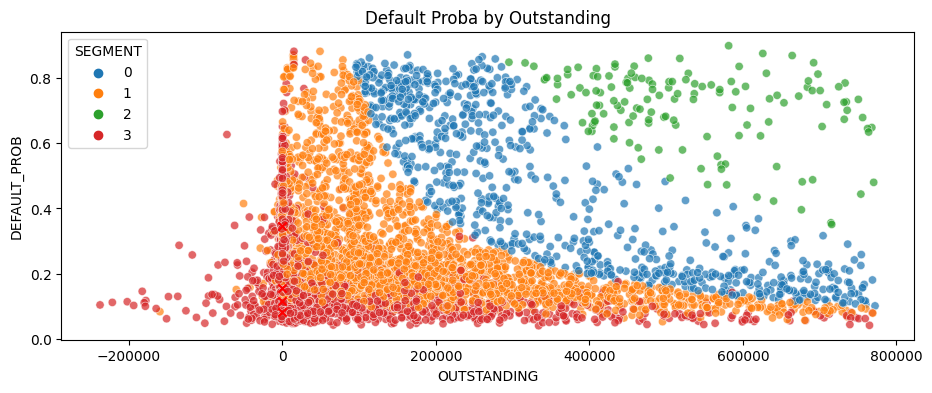

In [ ]:
# group by segments
segment_groups = default_df.groupby(by='SEGMENT')

# Get segment with highest default importance
highest_segment = np.argmax(segment_groups['DEFAULT_IMPORTANCE'].mean())
print('Highest default importance segment: SEGMENT', highest_segment)

# Get size of segment
print('Size of segment:', segment_groups.get_group(highest_segment).count()[0] / default_df.shape[0] * 100, '%')

print('Features used for clustering:', cols_for_clustering)
print('Weights:', weights)

# Plot scatterplot of segments
sns.scatterplot(data=default_df, x='OUTSTANDING', y='DEFAULT_PROB', hue='SEGMENT', palette='tab10', alpha=0.7);

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);
plt.title('Default Proba by Outstanding');

Text(0.5, 1.0, 'Default Importance by Limit Balance')

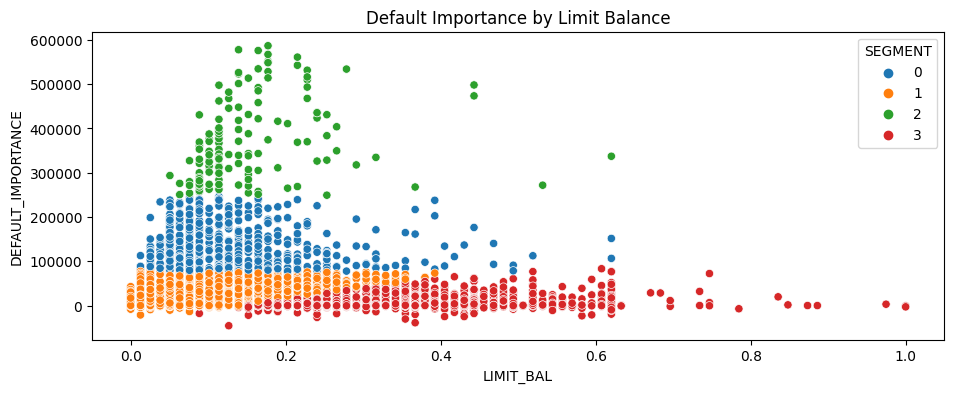

In [ ]:
# Plot scatterplot of segments
sns.scatterplot(data=default_df, x='LIMIT_BAL', y='DEFAULT_IMPORTANCE', hue='SEGMENT', palette='tab10');
plt.title('Default Importance by Limit Balance')

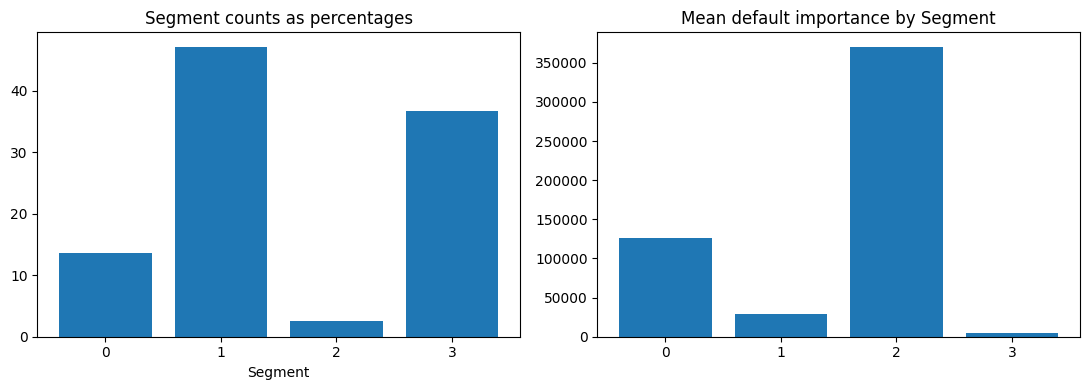

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.bar(segment_groups['ID'].count().keys(), segment_groups['ID'].count().values/segment_groups['ID'].count().sum()*100)
plt.xticks(range(k))
plt.xlabel('Segment')
plt.title('Segment counts as percentages');

segment_groups['ID'].count()

plt.subplot(1,2,2)
plt.bar(range(k), segment_groups['DEFAULT_IMPORTANCE'].mean())
plt.xticks(range(k))
plt.title('Mean default importance by Segment');

plt.tight_layout()

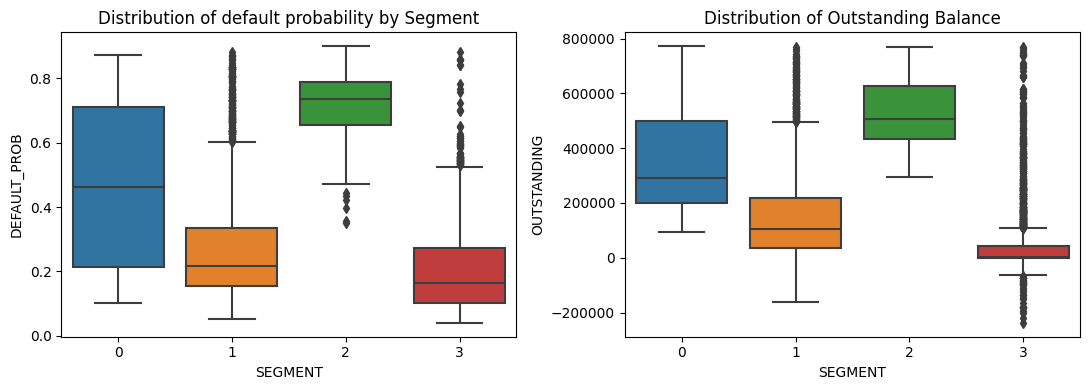

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='DEFAULT_PROB', data=default_df)
plt.title('Distribution of default probability by Segment');
segment_groups['DEFAULT_PROB'].mean().round(2)

plt.subplot(1,2,2)
sns.boxplot(x='SEGMENT', y='OUTSTANDING', data=default_df)
plt.title('Total bill amount for each segment');
plt.title('Distribution of Outstanding Balance');

plt.tight_layout()

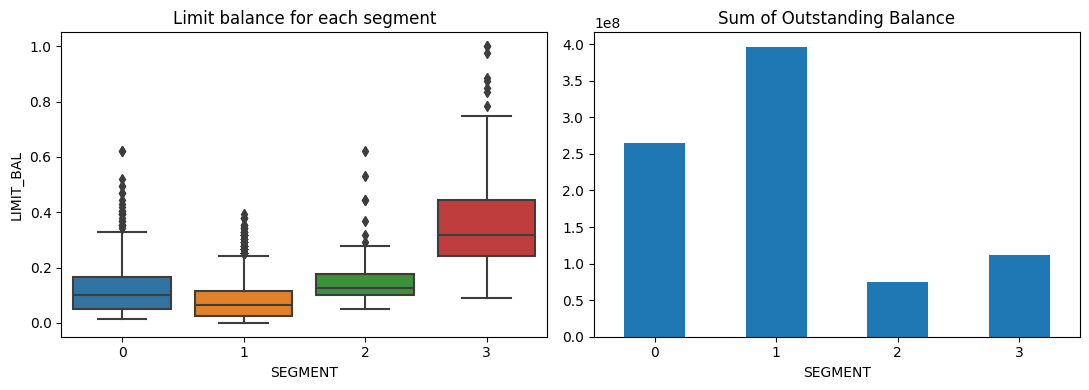

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='LIMIT_BAL', data=default_df, palette='tab10')
plt.title('Limit balance for each segment');

plt.subplot(1,2,2)
segment_groups['OUTSTANDING'].sum().plot(kind='bar', rot=0)
plt.title('Sum of Outstanding Balance');

plt.tight_layout()

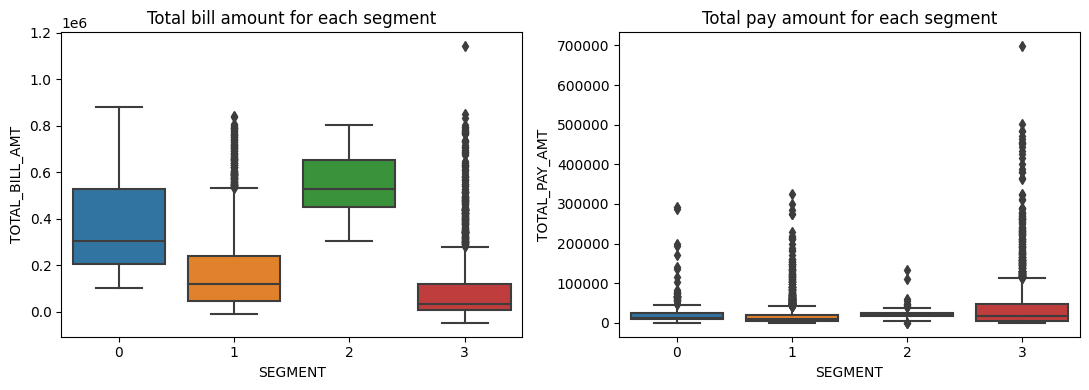

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='TOTAL_BILL_AMT', data=default_df)
plt.title('Total bill amount for each segment');

plt.subplot(1,2,2)
sns.boxplot(x='SEGMENT', y='TOTAL_PAY_AMT', data=default_df, palette='tab10')
plt.title('Total pay amount for each segment');

plt.tight_layout()

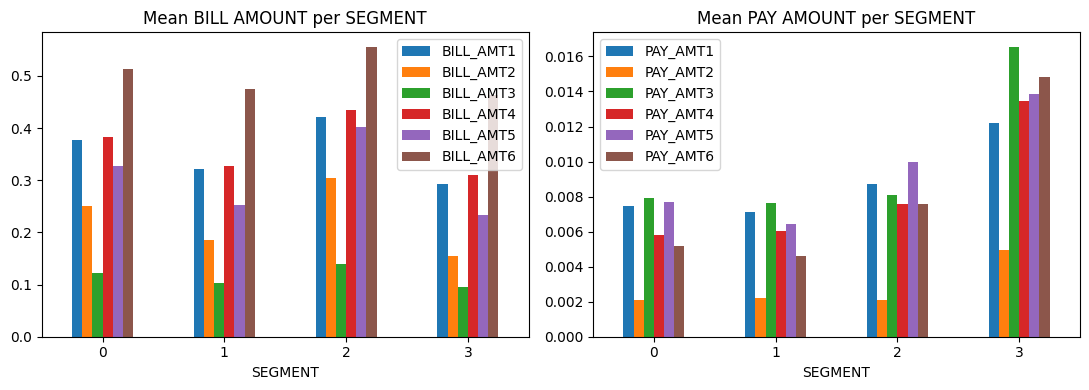

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
bill_amt_mean = segment_groups[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean()
bill_amt_mean.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('Mean BILL AMOUNT per SEGMENT');

plt.subplot(1,2,2)
pay_amt_mean = segment_groups[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean()

pay_amt_mean.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('Mean PAY AMOUNT per SEGMENT');

plt.tight_layout()

# the high risk/high default importance group has the highest mean bill amount in past 6 months.

In [ ]:
# Recategorize values not in data dictionary to 'Others'

default_df.loc[default_df['EDUCATION'] == 5, 'EDUCATION'] = 4
default_df.loc[default_df['EDUCATION'] == 6, 'EDUCATION'] = 4
default_df.loc[default_df['EDUCATION'] == 0, 'EDUCATION'] = 4

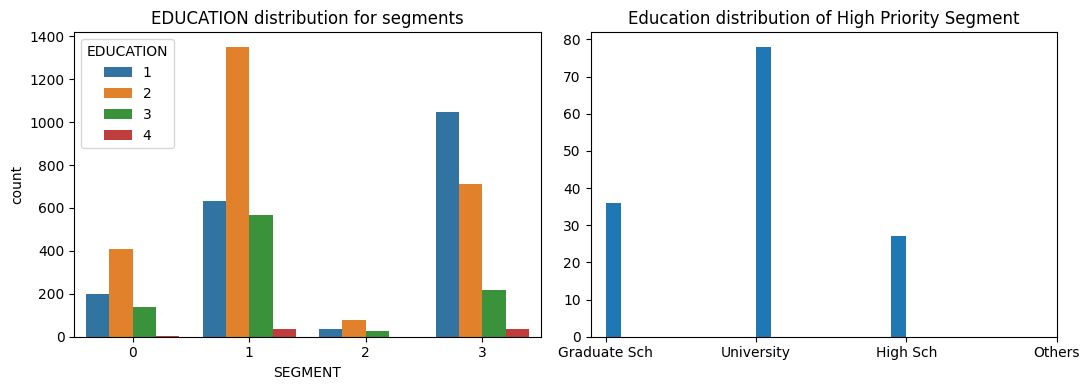

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.countplot(data=default_df, x="SEGMENT", hue="EDUCATION")
plt.title('EDUCATION distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['EDUCATION'].hist(bins=20)
plt.xticks([1,2,3,4], ['Graduate Sch', 'University', 'High Sch', 'Others'])
plt.title(f'Education distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()

# (1 = graduate school; 2 = university; 3 = high school; 4 = others)

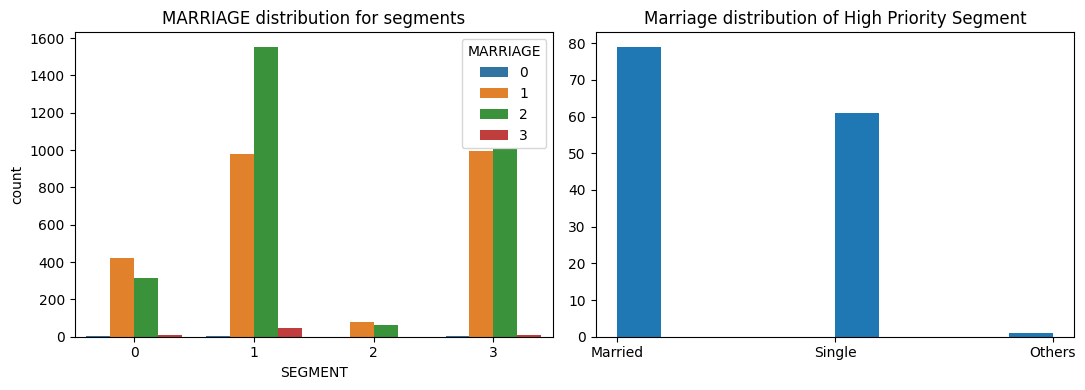

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.countplot(data=default_df, x='SEGMENT', hue="MARRIAGE")
plt.title('MARRIAGE distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['MARRIAGE'].hist(bins=10)
plt.xticks([1,2,3], ['Married', 'Single', 'Others'])
plt.title(f'Marriage distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()
# Marital status (1 = married; 2 = single; 3 = others)

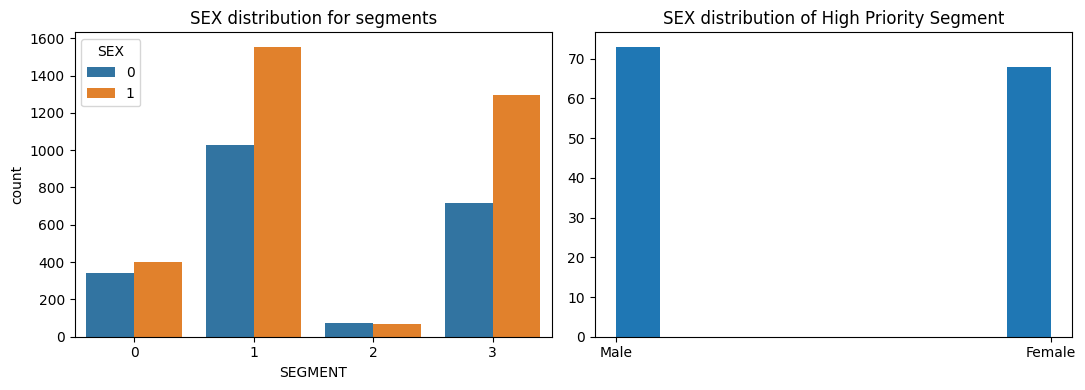

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.countplot(data=default_df, x="SEGMENT", hue="SEX")
plt.title('SEX distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['SEX'].hist(bins=10)
plt.xticks([0,1], ['Male', 'Female'])
plt.title(f'SEX distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()

# Overall population has more females than males

# **Demographics of 4 segments:**

by order of default importance: Segment 2, Segment 0, Segment 1, Segment 3

**Seg 2(highest priority: high outstanding, high prob)**


*   2.57% of all segments
*   high default probability, high outstanding

*   high default importance
*   highest median default probability

*   highest total bill amount (by median and distribution)
*   education distribution: university, graduate school, high school (similar with segment 0 and segment 1)

*   marriage distribution: more married than singles (different from segment 1)
*   sex distribution: more male than female (different from all other segments and the total population sex distribution)

**Seg 0(middle segment: low limit balance, relatively high default prob)**

*   relatively high default probability, the second highest outstanding balance
*   low limit balance but not the lowest, the second highest default importance
*   middle median default probability
*   the second highest total bill amount(by median)

*   the second highest mean bill amount, the second lowest mean payment amount
*   education distribution: university, graduate school, high school (similar with segment 2 and segment 1)

*   marriage distribution: more married than singles
*   sex distribution: more females than males (reflective of total population sex distribution)

**Seg 1(middle segment: low outstanding, relatively low default prob)**

*   relatively low default probability, low outstanding balance
*   the highest percentage of all population

*   lowest limit balance, relatively low default importance
*   the second lowest median default probability

*   the second lowest total bill amount (by median, with some outliers above segment 2)
*   the second lowest mean bill amount, the lowest bill payment amount

*   education distribution: university, graduate school, high school
*   merriage distribution: more singles than married

*   sex distribution: more females than males

**Seg 3 (lowest segment: lowest outstanding, low default prob)**

*   low default probability, lowest outstanding balance
*   highest limit balance, lowest default importance

*   lowest median default probability
*   lowest total bill amount (by median, with some outliers above segment 2)

*   lowest mean bill amount, highest mean payment amount
*   education distribution: graduate school, university, high school (has more higher education)

*   marriage distribution: slightly more singles than married
*   sex distribution: more females than males (reflective of total population sex distribution)






































